In [1]:
import TensorFlow
import Python

In [2]:
%include "PythonCheckpointReader.swift"

In [3]:
/*
 
*/
let layerToTensorMapping = [
    "block1_conv1": "layer_with_weights-0",
    "block1_conv2": "layer_with_weights-1",
    "block2_conv1": "layer_with_weights-2",
    "block2_conv2": "layer_with_weights-3",
    "block3_conv1": "layer_with_weights-4",
    "block3_conv2": "layer_with_weights-5",
    "block3_conv3": "layer_with_weights-6",
    "block3_conv4": "layer_with_weights-7",
    "block4_conv1": "layer_with_weights-8",
    "block4_conv2": "layer_with_weights-9",
    "block4_conv3": "layer_with_weights-10",
    "block4_conv4": "layer_with_weights-11",
    "block5_conv1": "layer_with_weights-12",
    "block5_conv2": "layer_with_weights-13",
    "block5_conv3": "layer_with_weights-14",
    "block5_conv4": "layer_with_weights-15"
]

In [4]:
func loadParameters(for tensorName: String) -> Tensor<Float>? {
    let suffix = "/.ATTRIBUTES/VARIABLE_VALUE"
    let fullName = "\(tensorName)\(suffix)"
    let fullTensorName = StringTensor([fullName])
    
    print("Loading saved parameters: \(fullName)")
    return Raw.restoreV2(prefix: StringTensor("./vgg-19.ckpt"), 
              tensorNames: fullTensorName, 
              shapeAndSlices: StringTensor([""]), 
              dtypes: [Float.tensorFlowDataType])[0] as! Tensor<Float>
}

In [5]:
func pretrainedConv2D(named name: String) -> Conv2D<Float> {
    return Conv2D(filter: loadParameters(for: "\(layerToTensorMapping[name]!)/kernel")!,
                  bias: loadParameters(for: "\(layerToTensorMapping[name]!)/bias")!, 
                  activation: relu,
                  strides: (1, 1),
                  padding: .same)
}

In [6]:
// Define the gram product. The Gram product is just a matrix's transpose multiplied by itself.
@differentiable
func gramProduct(of tensor: Tensor<Float>) -> Tensor<Float> {
    
    // Reshape to flatten the image dims to one dimension. Drop the batch dimension as well.
    let flatActivation = tensor.reshaped(to: TensorShape(tensor.shape[0], 
                                                         tensor.shape[1] * tensor.shape[2], 
                                                         tensor.shape[3])).squeezingShape(at: 0)
    // Transpose
    let actTransposed = flatActivation.transposed()

    // Take the matrix product of the transpose by the original.
    var gram = actTransposed • flatActivation
    
    // TODO: Might need to add the batch dimension back.
    gram =  gram / Float(tensor.shape[1] * tensor.shape[2])
    return gram
}

In [7]:
struct ImageTensorLayer: Layer {
    var imageTensor: Tensor<Float>
    
    init(imageTensor: Tensor<Float>) {
        self.imageTensor = imageTensor
    }
    @differentiable
    func call(_ input: Tensor<Float>) -> Tensor<Float> {
        return self.imageTensor
    }
}

In [8]:
struct OutputActivations: Differentiable {
    var activation1a:Tensor<Float>
    var style1a:Tensor<Float>
    var activation2a:Tensor<Float>
    var style2a:Tensor<Float>
    var activation3a:Tensor<Float>
    var style3a:Tensor<Float>
    var activation4a:Tensor<Float>
    var style4a:Tensor<Float>
    var activation4b:Tensor<Float>
    var activation5a:Tensor<Float>
    var style5a:Tensor<Float>
    
    @differentiable
    init(activation1a: Tensor<Float>,
         activation2a: Tensor<Float>,
         activation3a: Tensor<Float>,
         activation4a: Tensor<Float>,
         activation4b: Tensor<Float>,
         activation5a: Tensor<Float>) {
        self.activation1a = activation1a
        self.style1a = gramProduct(of: activation1a)
        
        self.activation2a = activation2a
        self.style2a = gramProduct(of: activation2a)
        
        self.activation3a = activation3a
        self.style3a = gramProduct(of: activation3a)
        
        self.activation4a = activation4a
        self.style4a = gramProduct(of: activation4a)
        
        self.activation4b = activation4b
        
        self.activation5a = activation5a
        self.style5a = gramProduct(of: activation5a)
    }
}

In [9]:
struct VGG19: Layer {
    var conv1a: Conv2D<Float>
    var conv1b: Conv2D<Float>
    
    var conv2a: Conv2D<Float>
    var conv2b: Conv2D<Float>
    
    var conv3a: Conv2D<Float>
    var conv3b: Conv2D<Float>
    var conv3c: Conv2D<Float>
    var conv3d: Conv2D<Float>
    
    var conv4a: Conv2D<Float>
    var conv4b: Conv2D<Float>
    var conv4c: Conv2D<Float>
    var conv4d: Conv2D<Float>
    
    var conv5a: Conv2D<Float>
    var conv5b: Conv2D<Float>
    var conv5c: Conv2D<Float>
    var conv5d: Conv2D<Float>
    
    var maxPool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool5 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    
    var avgPool1 = AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var avgPool2 = AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var avgPool3 = AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var avgPool4 = AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var avgPool5 = AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    
    init() {
        
        let strides = (1, 1)
        
        self.conv1a = pretrainedConv2D(named: "block1_conv1")
        self.conv1b = pretrainedConv2D(named: "block1_conv2")
        
// Layer 2
        self.conv2a = pretrainedConv2D(named: "block2_conv1")
        self.conv2b = pretrainedConv2D(named: "block2_conv2")
        
// Layer 3
        self.conv3a = pretrainedConv2D(named: "block3_conv1")
        self.conv3b = pretrainedConv2D(named: "block3_conv2")
        self.conv3c = pretrainedConv2D(named: "block3_conv3")
        self.conv3d = pretrainedConv2D(named: "block3_conv4")
        
// Layer 4
        self.conv4a = pretrainedConv2D(named: "block4_conv1")
        self.conv4b = pretrainedConv2D(named: "block4_conv2")
        self.conv4c = pretrainedConv2D(named: "block4_conv3")
        self.conv4d = pretrainedConv2D(named: "block4_conv4")
        
// Layer 5
        self.conv5a = pretrainedConv2D(named: "block5_conv1")
        self.conv5b = pretrainedConv2D(named: "block5_conv2")
        self.conv5c = pretrainedConv2D(named: "block5_conv3")
        self.conv5d = pretrainedConv2D(named: "block5_conv4")
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        var tmp = input
        
        // Layer 1
        tmp = conv1a(tmp)
        let act1a = tmp
        
        tmp = conv1b(tmp)
        tmp = maxPool1(tmp)
        
        // Layer 2 
        tmp = conv2a(tmp)
        let act2a = tmp
        tmp = conv2b(tmp)
        tmp = maxPool2(tmp)
        
        // Layer 3
        tmp = conv3a(tmp)
        let act3a = tmp
        tmp = conv3b(tmp)
        tmp = conv3c(tmp)
        tmp = conv3d(tmp)
        tmp = maxPool3(tmp)
        
        // Layer 4
        tmp = conv4a(tmp)
        let act4a = tmp
        tmp = conv4b(tmp)
        let act4b = tmp
        tmp = conv4c(tmp)
        tmp = conv4d(tmp)
        tmp = maxPool4( tmp)
        
        // Layer 5
        tmp = conv5a(tmp)
        let act5a = tmp
        tmp = conv5b(tmp)
        tmp = conv5c(tmp)
        tmp = conv5d(tmp)
        tmp = maxPool5(tmp)
        
        return OutputActivations(activation1a: act1a, 
                                 activation2a: act2a, 
                                 activation3a: act3a, 
                                 activation4a: act4a, 
                                 activation4b: act4b, 
                                 activation5a: act5a)
    }
}

In [10]:
let Image = Python.import("PIL.Image")

In [11]:
let np = Python.import("numpy")

In [12]:
enum ByteOrdering {
    case bgr
    case rgb
}

In [13]:
func loadImage(fileName: StringTensor) -> Tensor<UInt8> {
    let imageBytes: StringTensor = Raw.readFile(filename: fileName)
    return Raw.decodeJpeg(contents: imageBytes, dctMethod: "")
}

In [14]:
func preprocess(image: Tensor<UInt8>,
                size: Int,
                inByteOrdering: ByteOrdering,
                outByteOrdering: ByteOrdering,
                meanToSubtract: Tensor<Float>) -> Tensor<Float> {

    let sizeTensor = Tensor<Int32>([Int32(size), Int32(size)])
    var resizedImage = Tensor<Float>(Raw.resizeBicubic(images: image, 
                                                         size: sizeTensor))
    
    if inByteOrdering != outByteOrdering {
        resizedImage = Raw.reverse(resizedImage, dims: Tensor<Bool>([false, false, false, true]))
    }
    
    return resizedImage - meanToSubtract 
}

func postprocess(image: Tensor<Float>,
                 inByteOrdering: ByteOrdering,
                 outByteOrdering: ByteOrdering, 
                 meanToAdd: Tensor<Float>) -> Tensor<UInt8> {

    // Raw.reverse(meanToAdd, dims: Tensor<Bool>([true]))
    var processedImage = image + meanToAdd
    
    if inByteOrdering != outByteOrdering {
        processedImage = Raw.reverse(processedImage, dims: Tensor<Bool>([false, false, false, true]))
    }

    return Tensor<UInt8>(processedImage).squeezingShape(at: 0)
}

In [15]:
let meanRGB = Tensor<Float>([123.68, 116.779, 103.939])
let meanBGR = Raw.reverse(meanRGB, dims: Tensor<Bool>([true]))
print("RGB: \(meanRGB) BGR: \(meanBGR)")

RGB: [ 123.68, 116.779, 103.939] BGR: [103.939, 116.779,  123.68]


In [16]:
let contentImageBytes = loadImage(fileName:StringTensor("./puppy.jpg")).expandingShape(at: 0)

let contentImageTensor = preprocess(image: contentImageBytes, 
                                    size: 224, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: meanBGR)

let styleImageBytes = loadImage(fileName:StringTensor("./strokes.jpg")).expandingShape(at: 0)
let styleImageTensor = preprocess(image: styleImageBytes, 
                                  size: 224, 
                                  inByteOrdering: .rgb, 
                                  outByteOrdering: .bgr, 
                                  meanToSubtract: meanBGR)

In [17]:
// Setup.
%include "EnableIPythonDisplay.swift"
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [18]:
func showImageTensor(tensor: Tensor<Float>,
                     byteOrdering: ByteOrdering) {
    let pixelTensor = postprocess(image: tensor,
                                  inByteOrdering: byteOrdering, 
                                  outByteOrdering: .rgb, 
                                  meanToAdd: meanBGR)
    print(pixelTensor.shape)
    plt.imshow(pixelTensor.makeNumpyArray())
    plt.show()
}

TensorShape(dimensions: [224, 224, 3])
TensorShape(dimensions: [224, 224, 3])


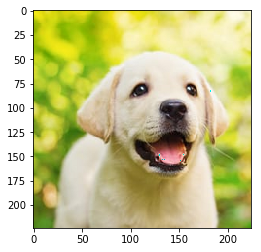

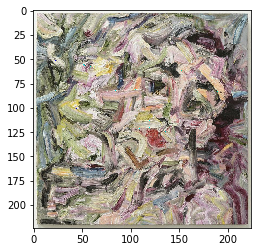

In [19]:
showImageTensor(tensor: contentImageTensor, byteOrdering: .bgr)
showImageTensor(tensor: styleImageTensor, byteOrdering: .bgr)

In [20]:
struct LossNet: Layer {
    var inputLayer: ImageTensorLayer
    var model: VGG19
    
    init(inputLayer: ImageTensorLayer, model: VGG19) {
        self.inputLayer = inputLayer
        self.model = model
    }
    
    @differentiable
    func call(_ input: Tensor<Float>) -> OutputActivations {
        let image = self.inputLayer(input)
        return model(image)
    }
}

In [21]:
var baseModel = VGG19()

Loading saved parameters: layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-2/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-2/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-3/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-3/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-4/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-4/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-5/kernel/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_weights-5/bias/.ATTRIBUTES/VARIABLE_VALUE
Loading saved parameters: layer_with_wei

In [22]:
let contentInputLayer = ImageTensorLayer(imageTensor: contentImageTensor)
let styleInputLayer = ImageTensorLayer(imageTensor: styleImageTensor)

var contentLossNet = LossNet(inputLayer: contentInputLayer, model: baseModel)
var styleLossNet = LossNet(inputLayer: styleInputLayer, model: baseModel)

### Compute the activations for the style and content layers. 

In [23]:
// Compute the content activations
let contentActivations = contentLossNet.inferring(from: contentImageTensor)

// Compute the style activations
let styleActivations = styleLossNet.inferring(from: styleImageTensor)

In [35]:
func zeroTensor(tensor: Tensor<Float>) -> Tensor<Float> {
    return Tensor<Float>(zeros: tensor.shape)
}

/// Adam optimizer.
///
/// Reference: ["Adam - A Method for Stochastic Optimization"](
/// https://arxiv.org/abs/1412.6980v8)
public class ImageAdam<Model: Layer>: Optimizer
    where Model.AllDifferentiableVariables == Model.CotangentVector {
    /// The learning rate.
    public var learningRate: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta1: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta2: Float
    /// A small scalar added to the denominator to improve numerical stability.
    public var epsilon: Float
    /// The weight decay.
    public var decay: Float
    /// The current step.
    public var step: Int = 0
    /// The first moments of the weights.
    public var firstMoments: Model.AllDifferentiableVariables
    /// The second moments of the weights.
    public var secondMoments: Model.AllDifferentiableVariables

    public init(
        for model: __shared Model,
        learningRate: Float = 1e-3,
        beta1: Float = 0.9,
        beta2: Float = 0.999,
        epsilon: Float = 1e-8,
        decay: Float = 0
    ) {
        precondition(learningRate >= 0, "Learning rate must be non-negative")
        precondition(0 <= beta1 && beta1 <= 1, "Beta parameter must be between 0 and 1")
        precondition(0 <= beta2 && beta2 <= 1, "Beta parameter must be between 0 and 1")
        precondition(decay >= 0, "Weight decay must be non-negative")

        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.decay = decay

        // Initialize first & second moments to be zeros of the same shape.
        // We can't use `Model.AllDifferentiableVariables.zero` due to the
        // interaction between Key Paths and Differentiable Arrays.
        firstMoments = model.allDifferentiableVariables
        secondMoments = model.allDifferentiableVariables
        for kp in firstMoments.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] = zeroTensor(tensor: firstMoments[keyPath: kp])
            secondMoments[keyPath: kp] = zeroTensor(tensor: secondMoments[keyPath: kp])
        }
    }


    public func update(_ model: inout Model.AllDifferentiableVariables,
                       along direction: Model.AllDifferentiableVariables) {
        step += 1
        let learningRate = self.learningRate * 1 / (1 + decay * Float(step))
        let stepSize = learningRate * (sqrt(1 - pow(beta2, Float(step))) /
            (1 - pow(beta1, Float(step))))
        
        // Update Float Tensor variables.
        for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] =
                firstMoments[keyPath: kp] * beta1 + (1 - beta1) * direction[keyPath: kp]
            secondMoments[keyPath: kp] =
                secondMoments[keyPath: kp] * beta2 + (1 - beta2) *
                direction[keyPath: kp] * direction[keyPath: kp]
            model[keyPath: kp] -=
                stepSize * firstMoments[keyPath: kp] / (sqrt(secondMoments[keyPath: kp]) + epsilon)
            break
        }
    }
}

In [25]:
@differentiable
public func MSELoss<Scalar: TensorFlowFloatingPoint>(
predicted: Tensor<Scalar>, expected: Tensor<Scalar>
) -> Tensor<Scalar> {
    
    return (expected - predicted).squared().mean()
}

In [199]:
@differentiable
public func totalVariationLoss(imageTensor: Tensor<Float>) -> Tensor<Float> { 
    
    let rank = imageTensor.rank
    let shape = imageTensor.shape
        
//     let diff1LowerLHS = Tensor<Int32>([Int32(0), Int32(1),            Int32(0),        Int32(0)])
//     let diff1SizeLHS = Tensor<Int32>( [Int32(1), Int32(shape[1] - 1), Int32(shape[2]), Int32(shape[3])])
    
    let diff1LowerUp = [0, 1,            0,            0]
    let diff1UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff1LowerDown = [0, 0,            0,            0]
    let diff1UpperDown = [1, shape[1] - 1, shape[2], shape[3]]
    
    let diff2LowerUp = [0, 0,            1,            0]
    let diff2UpperUp = [1, shape[1], shape[2], shape[3]]
    
    let diff2LowerDown = [0, 0,            0,            0]
    let diff2UpperDown = [1, shape[1], shape[2] - 1, shape[3]]
    
    let pixelDiff1 = imageTensor.slice(lowerBounds: diff1LowerUp, upperBounds: diff1UpperUp)
                     - imageTensor.slice(lowerBounds: diff1LowerDown, upperBounds: diff1UpperDown)
    
    let pixelDiff2 = imageTensor.slice(lowerBounds: diff2LowerUp, upperBounds: diff2UpperUp)
                     - imageTensor.slice(lowerBounds: diff2LowerDown, upperBounds: diff2UpperDown)
    
    return (pixelDiff1 * pixelDiff1).mean() + (pixelDiff2 * pixelDiff2).mean()
    
//     let diff2LowerRHS = Tensor<Int32>([Int32(0), Int32(0),            Int32(0),        Int32(0)])
//     let diff2SizeRHS = Tensor<Int32>( [Int32(1), Int32(shape[1] - 1), Int32(shape[2]), Int32(shape[3])])
    
//     let diff2LowerLHS = Tensor<Int32>([Int32(0), Int32(0),        Int32(1),            Int32(0)])
//     let diff2SizeLHS = Tensor<Int32>( [Int32(1), Int32(shape[1]), Int32(shape[2] - 1), Int32(shape[3])])
    
//     let diff2LowerRHS = Tensor<Int32>([Int32(0), Int32(0),        Int32(0),            Int32(0)])
//     let diff2SizeRHS = Tensor<Int32>( [Int32(1), Int32(shape[1]), Int32(shape[2] - 1), Int32(shape[3])])
    
//     let pixelDiff1 = 
//     imageTensor.slice(lowerBounds: diff1LowerLHS, 
//                       sizes: diff1SizeLHS)
//     -
//     imageTensor.slice(lowerBounds: diff1LowerRHS, 
//                       sizes: diff1SizeRHS)
        
//     let pixelDiff2 = 
//     imageTensor.slice(lowerBounds: diff2LowerLHS, 
//                       sizes: diff2SizeLHS)
//     -
//     imageTensor.slice(lowerBounds: diff2LowerRHS, 
//                       sizes: diff2SizeRHS)

//     return abs(pixelDiff1.sum()) + abs(pixelDiff2.sum())
}

In [27]:
@differentiable
func perceptualLoss(contentActivations: OutputActivations, 
                      styleActivations: OutputActivations,
                     targetActivations: OutputActivations,
                         contentWeight: Float,
                          styleWeights: [Float]) -> Tensor<Float> {
    
    var loss = MSELoss(predicted: targetActivations.activation4b, 
                        expected: contentActivations.activation4b) * contentWeight
    
    loss = loss + MSELoss(predicted: targetActivations.style1a, 
                           expected: styleActivations.style1a) * (styleWeights[0])
    
    loss = loss + MSELoss(predicted: targetActivations.style2a, 
                           expected: styleActivations.style2a) * (styleWeights[1])
    
    loss = loss + MSELoss(predicted: targetActivations.style3a, 
                           expected: styleActivations.style3a) * (styleWeights[2])
    
    loss = loss + MSELoss(predicted: targetActivations.style4a, 
                           expected: styleActivations.style4a) * (styleWeights[3] )
    
    loss = loss + MSELoss(predicted: targetActivations.style5a, 
                           expected: styleActivations.style5a) * (styleWeights[4])
    
    return loss
}

In [112]:
struct StyleTransferResult: CustomStringConvertible {
    var outputImages: [Tensor<Float>] = []
    
    let styleWeights: [Float]
    let contentWeight: Float
    let lr: Float
    let iterations: Int
    let saveEvery: Int
    
    var description: String {
        let description = """
               contentWeight: \(contentWeight)\n 
               styleWeights: \(styleWeights)\n
               lr: \(lr)\n
               iterations: \(iterations)\n
               saveEvery: \(saveEvery)\n
               """
        return description
    }
    
    init(styleWeights: [Float], 
         contentWeight: Float, 
         lr: Float, 
         iterations: Int,
         saveEvery: Int) {
        self.styleWeights = styleWeights
        self.contentWeight = contentWeight
        self.lr = lr
        self.iterations = iterations
        self.saveEvery = saveEvery
    }
    
    public func showImages() {
        let (rows, cols) = (Int(ceil(Float(outputImages.count) / Float(3.0))), 3)
        
        plt.figure(figsize: [15, 15])
        for i in 0..<(rows * cols) {
            if i  > outputImages.count - 1 {
                break
            }
            
            let img = plt.subplot(rows, cols, i + 1)
            img.axis("off")
            let pixelTensor = postprocess(image: outputImages[i],
                                          inByteOrdering: .bgr,
                                          outByteOrdering: .rgb,
                                          meanToAdd: meanBGR)
            
            let x = pixelTensor.makeNumpyArray()
            img.imshow(x)
            img.set_title("Iteration: \(i * saveEvery)")
        }
        
        plt.show()        
    }
}


In [203]:
func train(model: inout LossNet, 
              lr: Float, 
      iterations: Int = 450, 
   contentWeight: Float,
    styleWeights: [Float],
       saveEvery: Int) -> StyleTransferResult {
    let targetOptimizer = ImageAdam(for: model, learningRate: lr, beta1: 0.9, beta2: 0.999, epsilon: 1e-8)
    
    var result = StyleTransferResult(styleWeights: styleWeights, 
                                     contentWeight: contentWeight, 
                                     lr: lr, 
                                     iterations: iterations,
                                     saveEvery: saveEvery)
    
    for i in 0..<iterations {
        var lastLoss: Float = 0.0
        
        let 𝛁model = model.gradient { model -> Tensor<Float> in
            let targetActivations = model(model.inputLayer.imageTensor)
            var loss = perceptualLoss(contentActivations: contentActivations, 
                                        styleActivations: styleActivations, 
                                       targetActivations: targetActivations,
                                           contentWeight: contentWeight,
                                            styleWeights: styleWeights)
                                      
//             loss = loss + totalVariationLoss(imageTensor: model.inputLayer.imageTensor)

            lastLoss = loss.scalarized()
                                      
            return loss
        }
        
        targetOptimizer.update(&model.allDifferentiableVariables, along: 𝛁model)        
        
        if i % saveEvery == 0  {
            print("[Iteration \(i) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
        } else if i == iterations - 1 {
            print("[Iteration \(iterations) - Perceptual Loss: \(lastLoss)]")
            result.outputImages.append(model.inputLayer.imageTensor)
        }
    }
    
    return result
}

In [204]:
var results: [StyleTransferResult] = []

In [202]:
let targetImageTensor = preprocess(image: contentImageBytes, 
                                    size: 224, 
                                    inByteOrdering: .rgb, 
                                    outByteOrdering: .bgr,
                                    meanToSubtract: meanBGR)

let targetInputLayer = ImageTensorLayer(imageTensor: targetImageTensor)

var targetLossNet = LossNet(inputLayer: targetInputLayer, model: baseModel)
let styleWeights: [Float] = [
Float(1e3 / Float(pow( 32.0 , 2.0))),
Float(1e3 / Float(pow( 32.0, 2.0))),
Float(1e3 / Float(pow( 64.0, 2.0))),
Float(1e3 / Float(pow( 512.0, 2.0))),
Float(1e3 / Float(pow( 512.0, 2.0)))]

let lr: Float = 4.0
let iterations = 2000
let contentWeight:Float = 1.0

results.append(train(model: &targetLossNet, 
                        lr: lr, 
                iterations: iterations,
             contentWeight: contentWeight,
              styleWeights: styleWeights,
                 saveEvery: 100))

[Iteration 0 - Perceptual Loss: 1.8393902e+09]
[Iteration 100 - Perceptual Loss: 2.7307794e+09]
Fatal error: OOM when allocating tensor with shape[1,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc: file /swift-base/swift/stdlib/public/TensorFlow/CompilerRuntime.swift, line 2108
Current stack trace:
0    libswiftCore.so                    0x00007f881c17ce00 _swift_stdlib_reportFatalErrorInFile + 115
1    libswiftCore.so                    0x00007f881c0c506c <unavailable> + 3035244
2    libswiftCore.so                    0x00007f881c0c515e <unavailable> + 3035486
3    libswiftCore.so                    0x00007f881bf0ca12 <unavailable> + 1231378
4    libswiftCore.so                    0x00007f881c091d42 <unavailable> + 2825538
5    libswiftCore.so                    0x00007f881bf0bef9 <unavailable> + 1228537
6    libswiftTensorFlow.so              0x00007f8819704022 <unavailable> + 598050
7    libswiftTensorFlow.so              0x00007f881

: 

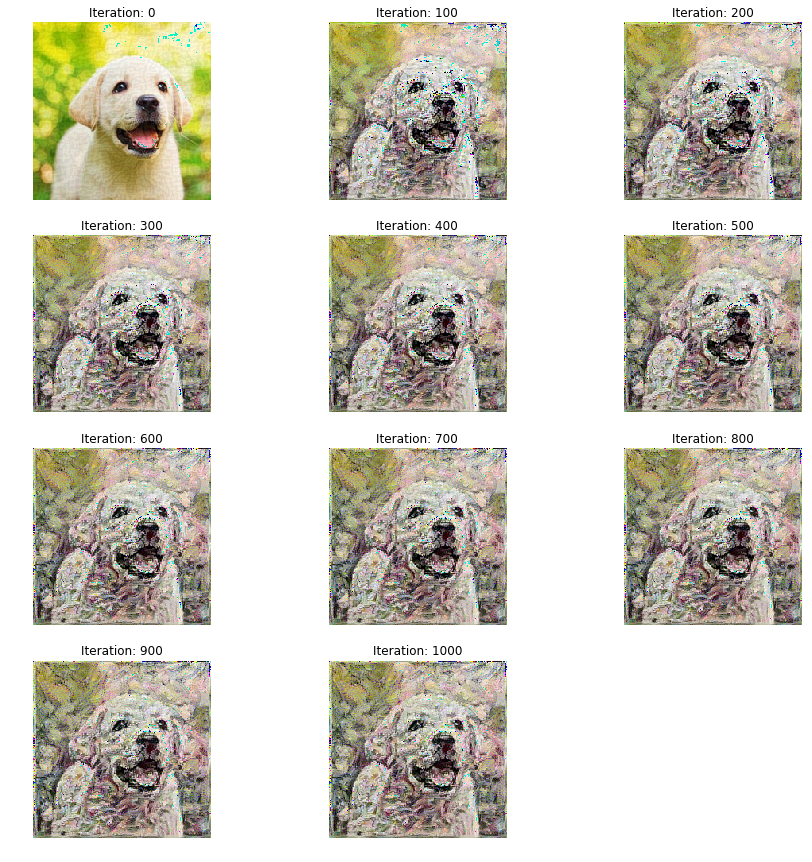

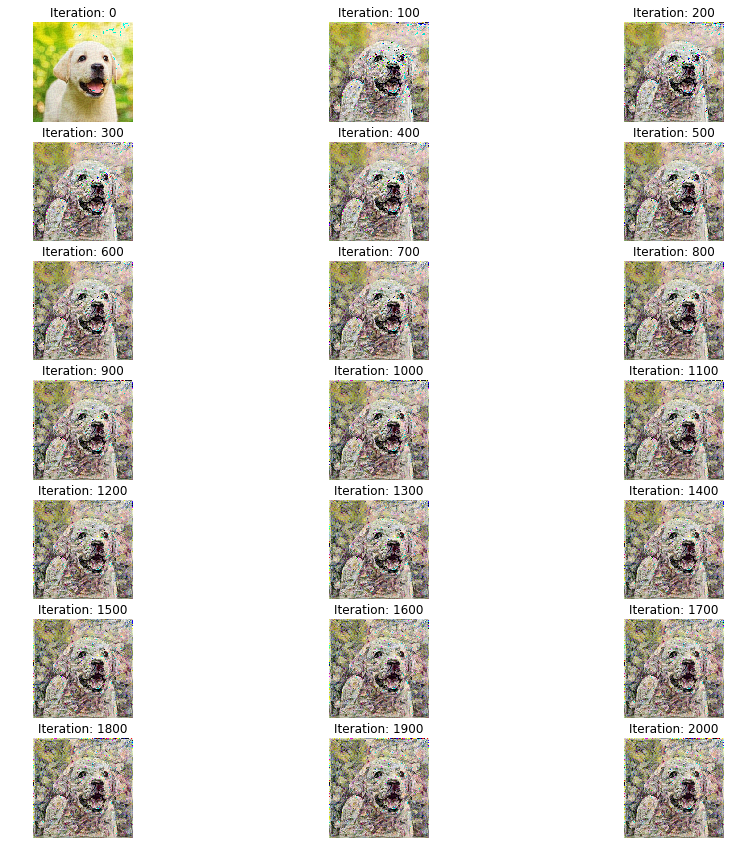

In [123]:
for result in results {
    result.showImages()
//     print(result.outputImages.last)
}

TensorShape(dimensions: [224, 224, 3])


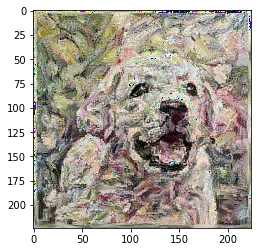

In [131]:
let result = results.last!.outputImages[20]
showImageTensor(tensor: result, byteOrdering: .bgr)

In [190]:
// let sobelX = Tensor<Float>([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
// let sobelXFilter = sobelX.reshaped(to: [1, 3, 3, 1]).broadcast(toShape: [1, 3, 3, 3])
// let sobelYFilter = sobelXFilter.transposed(withPermutations: [1, 0, 2, 3])
// print(sobelYFilter.shape)

let filterXY = highPassXY(imageTensor: result)

TensorShape(dimensions: [224, 223, 3])
TensorShape(dimensions: [223, 224, 3])
TensorShape(dimensions: [224, 224, 3])


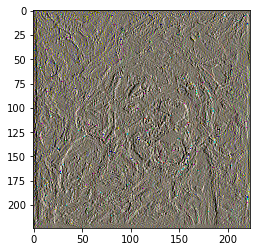

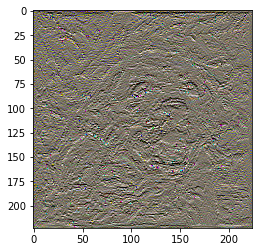

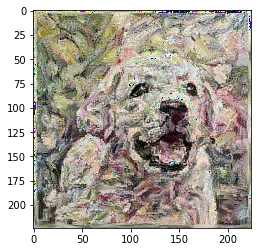

In [197]:
let sobelImg = contentImageTensor.convolved2D(withFilter: sobelXFilter, 
                                  strides: (1, 1, 1, 1), 
                                  padding: .same)
showImageTensor(tensor: filterXY[1], byteOrdering: .bgr)
showImageTensor(tensor: filterXY[0], byteOrdering: .bgr)
showImageTensor(tensor: result, byteOrdering: .bgr)

TensorShape(dimensions: [224, 224, 3])


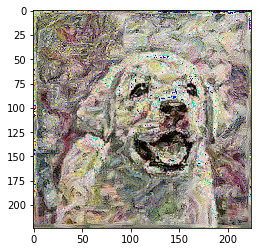

In [39]:
showImageTensor(tensor: output, byteOrdering: .rgb)

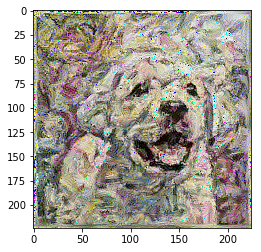

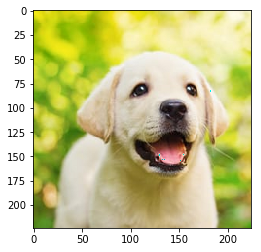

In [34]:
showImageTensor(tensor: testImageBatch.squeezingShape(at: 0) + mean)

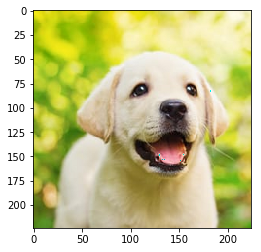

In [35]:
showImageTensor(tensor: testImageTensor)

In [36]:
print(meanSquaredError(predicted: testImageBatch.squeezingShape(at: 0) + mean, expected: testImageTensor))

2.206066e-12
